# Disease Impact on Cardiac Proliferation and Regeneration Pathway Regulation

### In this notebook, I will work towards extracting the necessary data for a ReactomeGSA Pathway analysis that will help identify the cardiac proliferation and regeneration pathways that are upregulated and downregulated as a result of disease. 

#### I will:
###### 1) I will extract all of the UniProt IDs of the proteins that were identified in the samples that I had selected for an Integrated Proteomics Pipeline (IP2) analysis. The samples will then be separated into two groups: 1) proteins from disease samples and 2) proteins from control samples.
###### 2) After obtaining the list of genes implicated in cardiac proliferation and regeneration from the scRNA analysis conducted previously, these genes will be mapped to UniProtKB IDs. I can then determing which proteins in the disease protein set and the control protein set are involved in cardiac proliferation and generation. A Reactome pathway analysis will be run on the proteins on the proliferation/regeneration proteins that are not present in both sets. This will help gain insight into any uniquenesses found in either set. 
###### 3) Only two experiments from the PRoteomics IDEntification Database will be used to elucidate proliferation/regeneration pathways whose regulation are impacted by disease. The end of this notebook will include an extraction of the protein quantification data used for this ReactomeGSA analysis. 

In [ ]:
!ls
! unzip All_Data-20221114T223200Z-001.zip

In [ ]:
!ls Data/

## Protein Counts in Each Experiment
### Here I will extract the proteins from each experiment and determine the number of protein overlaps between every experiment combination. I will also be able to find the number of nonredundant disease related proteins and nonredundant proteins from control samples across all experiments. 

In [239]:
# Create a function to extract protein and spectral counts in the text files
def extract_protein_and_spec(file_with_prots_and_spec: list) -> list:
    proteins = []
    spec_counts = []
    for line in file_with_prots_and_spec:
        if '|' in line:
            #print(line)
            protein_name = line.split('|')[1]
            proteins.append(protein_name)
            count = line.split('\t')[2]
            spec_counts.append(count)
    return proteins, spec_counts


In [240]:
import os

def load_data(data_folder='./data', debug=False):
    DISEASE_TAG = "Disease"
    CONTROL_TAG = "Control"
    EXPERIMENT_TAG = "Experiment"
    
    # This dict maps experiment name --> list of files
    experiment_to_data_files = {}
    
    # This dict maps experiment name --> list of nonredundant proteins for that experiment
    experiment_to_proteins = {}
    
    # This dict maps experiment name --> number of total nonredundant proteins for the investigation
    experiment_to_protein_counts = {}
    
  
    total_proteins = []  #proteins across all experiments
    disease_prots = []   #proteins found in disease samples
    control_prots = []  #proteins found in control samples
    
    # loop through all folders in data folder; contains experiment folders
    for file in os.listdir(data_folder): 
        
        #is it an experiment folder or not?
        is_experiment = EXPERIMENT_TAG in file
        
        
        # if it is an experiment, get path to that experiment
        if is_experiment:
            
            experiment_folder = os.path.join(data_folder, file)
            
            all_files = []
            all_nonredundant_proteins = []
            
       
            # loop through all files in the experiment folder
            for data_file in os.listdir(experiment_folder):
            
                data_file_path = os.path.join(experiment_folder, data_file) #e.g. ./data/PXDXXX/Prosser_XXX.txt
            
                if data_file != '.ipynb_checkpoints':
                    
                    all_files += [data_file]
            
                    # store experiment -> list of files
                    experiment_to_data_files[file] = all_files
                
                    open_data_file = open(data_file_path, 'r').read().split("\n")

                    #extract the protein list for this data_file
                    protein_list = extract_protein_and_spec(open_data_file)[0]

                    for prot in protein_list:
                        if prot not in all_nonredundant_proteins:
                            all_nonredundant_proteins.append(prot)
                        if prot not in total_proteins:
                            if len(prot) > 0:
                                total_proteins.append(prot)
                        if DISEASE_TAG in data_file:
                            if prot not in disease_prots:
                                if len(prot) > 0:
                                    disease_prots.append(prot)
                        if CONTROL_TAG in data_file:
                            if prot not in control_prots:
                                if len(prot) > 0:
                                    control_prots.append(prot)
                    
            prots_count = len(all_nonredundant_proteins)
            
            #store experiment -> list of nonredundant proteins
            experiment_to_proteins[file] = all_nonredundant_proteins
            
            #store experiment -> nonredundant protein count for that file
            experiment_to_protein_counts[file] = prots_count
            
    return experiment_to_data_files, experiment_to_proteins, experiment_to_protein_counts, total_proteins, control_prots, disease_prots
        
data_folder = './Data'

experiment_to_data_files, experiment_to_proteins, experiment_to_protein_counts, total_proteins, control_prots, disease_prots = load_data(data_folder)

print("We have extracted a total of %s nonredundant proteins." %len(total_proteins))
print("The control samples include a total of %s nonredundant proteins." %len(control_prots))
print("The disease samples include a total of %s nonredundant proteins." %len(disease_prots))

We have extracted a total of 3956 nonredundant proteins.
The control samples include a total of 1203 nonredundant proteins.
The disease samples include a total of 3696 nonredundant proteins.


In [241]:
#identifying the proteins that are in both lists

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
 
both_disease_and_control = intersection(control_prots, disease_prots)

print("There are %s nonredundant proteins that are found in both disease and control sets." %len(both_disease_and_control))

There are 1163 nonredundant proteins that are found in both disease and control sets.


In [242]:
from itertools import combinations

#this function generations all combinations of experiment names for later use
def get_combinations(my_list):
    combs = []
    for size in (range(2,len(my_list)+1)):
        combs += list(combinations(my_list,size))
    
    return combs

combs = get_combinations(experiment_to_data_files.keys())
combs

[('PXD011349_Experiment', 'PXD018678_Experiment'),
 ('PXD011349_Experiment', 'PXD023778_Experiment'),
 ('PXD011349_Experiment', 'PXD008934_Experiment'),
 ('PXD018678_Experiment', 'PXD023778_Experiment'),
 ('PXD018678_Experiment', 'PXD008934_Experiment'),
 ('PXD023778_Experiment', 'PXD008934_Experiment'),
 ('PXD011349_Experiment', 'PXD018678_Experiment', 'PXD023778_Experiment'),
 ('PXD011349_Experiment', 'PXD018678_Experiment', 'PXD008934_Experiment'),
 ('PXD011349_Experiment', 'PXD023778_Experiment', 'PXD008934_Experiment'),
 ('PXD018678_Experiment', 'PXD023778_Experiment', 'PXD008934_Experiment'),
 ('PXD011349_Experiment',
  'PXD018678_Experiment',
  'PXD023778_Experiment',
  'PXD008934_Experiment')]

In [243]:
import pandas as pd

#this function generations a dataframe to indicate whether a protein is found within an experiment or combination of experiments
def protein_distribution(all_proteins, experiment_combinations, experiment_to_proteins):
    
    #all of the proteins will be in the index column of this dataframe
    df = pd.DataFrame(all_proteins)
    df = df.rename(columns = {0: 'All Proteins'})
    df = df.set_index('All Proteins')
    
    #converting experiment_to_proteins dict to a list
    exp_to_prots_list = list(experiment_to_proteins.values())
    
    # Write if protein is present in a given list
    for i, j in zip(experiment_to_proteins.keys(), range(4)):
        df[i] = [True if x in exp_to_prots_list[j] else False for x in all_proteins]
        
    for combination in experiment_combinations:
        
        #access the data in the experiment columns of current interest
        experiments_interest = [x for x in combination]
        
        #if the experiments of interest have the protein and 
        df[combination] = ((df[experiments_interest]).all(bool_only=True,axis='columns')) 
    
    return df

protein_distribution = protein_distribution(total_proteins, combs, experiment_to_proteins)

protein_distribution

counts = []
for col_name in df.columns:
    counts.append(df[col_name].sum())
    
counts

[1022,
 3318,
 1068,
 1647,
 833,
 550,
 708,
 786,
 1386,
 722,
 527,
 676,
 497,
 674,
 488]

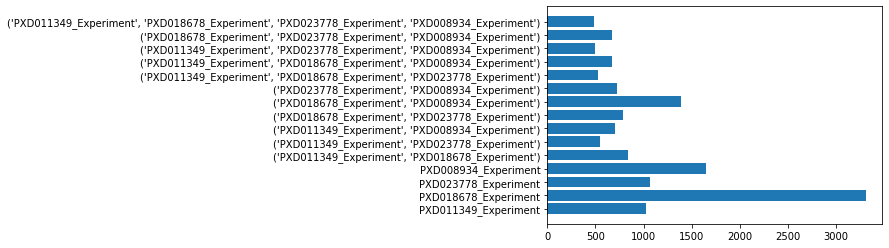

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [244]:
import matplotlib.pyplot as plt
import numpy as np

#this function generates a bar graph of the protein distributions in the experiments

def plot_prots_distribution(dataframe):
    
    #obtaining counts for each column
    counts = []
    for col_name in df.columns:
        counts.append(df[col_name].sum())
        
    Y_axis = np.arange(len(df.columns))
    plt.barh(Y_axis, counts)
    plt.yticks(Y_axis, df.columns)
    plt.show()
    
    return plt

combintations_bargraph = plot_prots_distribution(protein_distribution)

combintations_bargraph

In [249]:
#this function generates an upset plot of the protein distribution within each category and its combinations

def upset_plot(dataframe):

    upset_plot_dict = {}
    for col_name in dataframe.columns[4:]:
        num_true = dataframe[col_name].sum()
            
        upset_plot_dict[col_name] = num_true
        
    multi_index_categories = get_bool_table(list(upset_plot_dict.keys()))

    data_series = pd.Series(data=upset_plot_dict.values(),index=multi_index_categories)
    upset_plot = upplot(data_series)


    
    return upset_plot

upset_plot = upset_plot(protein_distribution)

upset_plot

NameError: name 'get_bool_table' is not defined

[Text(0.5, 14.09375, 'Experiment')]

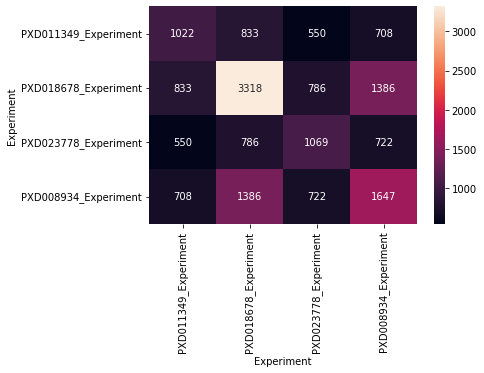

In [148]:
#this function generates a heatmap to visualize how many proteins are shared between experiment pairs

import seaborn as sns
import pandas as pd

def experiment_pairs_heatmap(experiment_to_proteins):
    
    #all of the proteins will be in the index column of this dataframe
    df_for_heatmap = pd.DataFrame(experiment_to_proteins.keys())
    df_for_heatmap = df_for_heatmap.rename(columns = {0: 'Experiment'})
    df_for_heatmap = df_for_heatmap.set_index('Experiment')
    
    #populating the dataframe with the correct values for heatmap generation
    for exp1 in experiment_to_proteins.keys():
        new_col_values = []
        for exp2 in experiment_to_proteins.keys():
            counter = 0
            for prot in experiment_to_proteins[exp1]:
                    if prot in experiment_to_proteins[exp2]:
                        counter = counter + 1
            new_col_values.append(counter)
        df_for_heatmap[exp1] = new_col_values
    
    #plotting the heatmap
    plot = sns.heatmap(df_for_heatmap, annot = True, fmt='.4g')
    plot = plot.set(xlabel = "Experiment")
    
    return plot

pairs_heatmap = experiment_pairs_heatmap(experiment_to_proteins)

pairs_heatmap

# Proteins Not Related to Proliferation/Regeneration in Disease Samples and Control Samples

### An investigation into the double-injury model in neonate pigs allowed for the generation of scRNA data. Genes implicated in proliferation/generation were extracted and compared to the disease and control samples. 

In [205]:
#extracting the proliferation/generation protein data

import json
def proliferation_regeneration(file_path):
    with open(file_path, 'r') as f:
        from_genes = json.load(f)

    prolif_regen_prots = list(from_genes.values())

    all_prolif_regen_prots = []

    for items in prolif_regen_prots:
        for item in items:
            all_prolif_regen_prots.append(item)
    return all_prolif_regen_prots

all_prolif_regen_prots = proliferation_regeneration('./Data/gene_name_to_uniprot_id.json')
        
print("From the scRNA data we have obtained %s proteins." %len(all_prolif_regen_prots))
print("%s proteins in the control set are proliferation/regeneration proteins." %len(intersection(control_prots, all_prolif_regen_prots)))
print("%s proteins in the control set are not proliferation/regeneration proteins." %(len(control_prots) - len(intersection(control_prots, all_prolif_regen_prots))))
print("%s proteins in the disease set are proliferation/regeneration proteins." %len(intersection(disease_prots, all_prolif_regen_prots)))
print("%s proteins in the disease set are not proliferation/regeneration proteins." %(len(disease_prots) - len(intersection(disease_prots, all_prolif_regen_prots))))
print("The fraction of proteins in the control set that are not proliferation/regeneration proteins is %s." %(1-((len(intersection(control_prots, all_prolif_regen_prots)))/(len(control_prots)))))
print("The fraction of proteins in the disease set that are not proliferation/regeneration proteins is %s." %(1-((len(intersection(disease_prots, all_prolif_regen_prots)))/(len(disease_prots)))))


From the scRNA data we have obtained 87005 proteins.
1050 proteins in the control set are proliferation/regeneration proteins.
153 proteins in the control set are not proliferation/regeneration proteins.
3175 proteins in the disease set are proliferation/regeneration proteins.
521 proteins in the disease set are not proliferation/regeneration proteins.
The fraction of proteins in the control set that are not proliferation/regeneration proteins is 0.1271820448877805.
The fraction of proteins in the disease set that are not proliferation/regeneration proteins is 0.14096320346320346.


#### I am curious about the proteins that are not related to proliferation and regeneration in each set. I will conduct a Reactome pathway analysis on these proteins to gain more insight.

In [208]:
#extracting the proteins that are not related to proliferation and regeneration for Reactome analysis

def non_proliferation_regeneration(control_prots, disease_prots, all_prolif_regen_prots):

    non_prolif_regen_control = []
    for prot in control_prots:
        if prot not in all_prolif_regen_prots:
            non_prolif_regen_control.append(prot)
    
    non_prolif_regen_disease = []
    for prot in disease_prots:
        if prot not in all_prolif_regen_prots:
            non_prolif_regen_disease.append(prot)
    
    return non_prolif_regen_control, non_prolif_regen_disease

non_prolif_regen_control, non_prolif_regen_disease = non_proliferation_regeneration(control_prots, disease_prots, all_prolif_regen_prots)

In [210]:
#writing them to a text file for use in Reactome analysis
with open('non_prolif_regen_control.txt', 'w') as f:
   for element in non_prolif_regen_control:
       f.write(element + '\n')
        
with open('non_prolif_regen_disease.txt', 'w') as f:
   for element in non_prolif_regen_disease:
       f.write(element + '\n')

# Extraction of Protein Intensity Quantification Values for Reactome GSA Analysis

### Here I will prepare the files that I will used for the ReactomeGSA analysis. Only experiments PXD023778 and PXD008934 will be used for this portion of the investigation. The analysis will help determine how cardiac proliferation and regeneration pathways are impacted by the onset of disease.

PXD023778

In [254]:
import pandas as pd

def prepare_TMT(TMT1_csv, TMT2_csv, prolif_regen_prots):
    
    #load the csvs
    TMT1 = pd.read_csv(TMT1_csv)
    TMT2 = pd.read_csv(TMT2_csv)
    
    #create the accession to be the index in each of the dataframes
    TMT1 = TMT1.set_index('accession')
    TMT2 = TMT2.set_index('accession')
    
    #drop the columns that will not be needed for Reactome
    TMT1 = TMT1.drop(['spec count', 'peptide num', 'description'], axis=1)
    TMT2 = TMT2.drop(['spec count', 'peptide num', 'description'], axis=1)
    TMT1 = TMT1.loc[:,~TMT1.columns.str.contains('^avg', case=False)]
    TMT2 = TMT2.loc[:,~TMT2.columns.str.contains('^avg', case=False)]
    TMT2 = TMT2.add_suffix('_2')
    
    #merging the two dataframes into one
    TMT = pd.concat([TMT1, TMT2], axis=1)
    
    #removing rows with contaminants and reverse sequences
    TMT = TMT[TMT.index.str.contains("Reverse|contaminant") == False]
    
    #removing rows that are not proliferation or regeneration proteins
    for prot in TMT.index:
         if prot not in prolif_regen_prots:
              TMT = TMT[TMT.index.str.contains(prot) == False]
    
    #log2 transform the dataframe
    TMT = TMT.applymap(np.log2)
    
    return TMT

TMT = prepare_TMT('./Data/TMT1_Intensities.csv', './Data/TMT2_Intensities.csv', all_prolif_regen_prots)

TMT

,norm int m/z_126.127725,norm int m/z_127.12476,norm int m/z_128.134433,norm int m/z_129.131468,norm int m/z_130.141141,norm int m/z_131.138176,norm int m/z_126.127725_2,norm int m/z_127.12476_2,norm int m/z_128.134433_2,norm int m/z_129.131468_2,norm int m/z_130.141141_2,norm int m/z_131.138176_2
accession,,,,,,,,,,,,
P05413,21.707530,21.844632,21.483896,22.185584,21.753813,21.795066,21.827544,21.975741,21.545391,22.364311,21.867103,21.904687
Q99623,20.025080,20.121633,20.086952,20.102822,20.147055,20.066549,19.964762,19.993694,19.976327,20.087602,20.083529,20.065778
P04792,19.518296,19.847542,19.704428,19.812520,19.751481,19.893138,19.764996,20.185596,20.021808,20.182164,20.084169,20.278700
P99999,19.783661,20.070656,19.660202,19.968243,20.130078,19.769371,19.919097,20.150686,19.797287,20.263659,20.391596,19.989614
P07951,19.262036,19.442948,19.280226,19.175795,19.005510,19.054925,19.364869,19.513622,19.343981,19.284718,19.096441,19.193429
...,...,...,...,...,...,...,...,...,...,...,...,...
Q8NDA2,NaN,NaN,NaN,NaN,NaN,NaN,21.061802,21.038920,21.097628,21.125360,21.036021,21.125979
Q8NEZ4,NaN,NaN,NaN,NaN,NaN,NaN,17.481713,17.626561,17.389564,17.333474,17.779254,17.448741
Q9NYQ8,NaN,NaN,NaN,NaN,NaN,NaN,20.897750,21.300597,20.551512,20.015933,19.883925,20.273794


In [258]:
#writing dataframe to csv
TMT.to_csv("TMT_for_Reactome.csv")

PXD008934

In [256]:
import pandas as pd

def prepare_Prosser_files(data_folder, prolif_regen_prots):
  
    PXD008934_TAG = "PXD008934"
    counter = 0
    
    # loop through all folders in data folder
    for file in os.listdir(data_folder): 
        
        #is it correct experiment folder or not?
        is_PXD008934 = PXD008934_TAG in file
        
        if is_PXD008934:
            
            PXD008934_folder = os.path.join(data_folder, file)
            
            # loop through all files in the experiment folder
            for data_file in os.listdir(PXD008934_folder):
            
                counter = counter + 1
                
                data_file_path = os.path.join(PXD008934_folder, data_file) #e.g. ./data/PXDXXX/Prosser_XXX.txt
            
                if data_file != '.ipynb_checkpoints':
                
                    open_data_file = open(data_file_path, 'r').read().split("\n")

                    #extract the protein list for this data_file
                    protein_list = extract_protein_and_spec(open_data_file)[0]
                    
                    #extract the spec counts for this data_file
                    spec_counts = extract_protein_and_spec(open_data_file)[1]
                    
                    #This dict map protein name --> spec count
                    protein_to_spec_count = {}
                    
                    #populated the protein_to_spec_count dict:
                    for prot, spec_value in zip(protein_list, spec_counts):
                        protein_to_spec_count[prot] = spec_value
                        
                    if counter == 1:
                        df_spec_count = pd.DataFrame.from_dict(protein_to_spec_count, orient = 'index', columns = [data_file])
                        #spec_count_df = pd.concat([df_to_add, spec_count_df])
                        
                    if counter != 1:
                        df_to_add = pd.DataFrame.from_dict(protein_to_spec_count, orient = 'index', columns = [data_file])
                        df_spec_count = pd.concat([df_spec_count, df_to_add], axis = 1)
                        
    #removing rows that are not proliferation or regeneration proteins
    for prot in df_spec_count.index:
         if prot not in prolif_regen_prots:
            df_spec_count = df_spec_count[df_spec_count.index.str.contains(prot) == False]
        
    
    return df_spec_count
                        

data_folder = './Data'
df_spec_count = prepare_Prosser_files(data_folder, all_prolif_regen_prots)

df_spec_count

,Prosser_1383_Control.txt,Prosser_1195_Disease.txt,Prosser_1427_Disease.txt,Prosser_1136_Disease.txt,Prosser_1325_Control.txt,Prosser_1467_Disease.txt,Prosser_1119_Disease.txt,Prosser_1085_Control.txt,Prosser_1198_Disease.txt,Prosser_1228_Disease.txt,...,Prosser_1339_Control.txt,Prosser_1004_Disease.txt,Prosser_1602_Disease.txt,Prosser_1356_Control.txt,Prosser_1320_Disease.txt,Prosser_1209_Disease.txt,Prosser_1379_Disease.txt,Prosser_1304_Disease.txt,Prosser_1472_Disease.txt,Prosser_1086_Disease.txt
P05413,45,44,50,53,56,51,61,66,51,50,...,55,51,59,58,42,49,55,45,50,52
P56385,23,10,16,13,13,7,14,18,9,16,...,12,24,18,26,NaN,16,14,11,17,17
P09493,28,35,28,31,32,31,35,32,23,19,...,34,35,23,35,26,27,30,28,19,31
P07951,21,24,16,27,24,22,28,22,15,16,...,24,33,17,25,21,19,20,20,14,22
P68871,32,52,41,14,17,35,27,15,78,33,...,9,50,38,27,89,40,29,31,47,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P32455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
P32456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
O94885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
O60333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [257]:
#writing dataframe to csv
df_spec_count.to_csv("Spec_for_Reactome.csv")